# Reinforcement Learning Lab Sheet
## Intrinsically Motivated Reinforcement Learning

In this lab sheet, you will augment a standard **tabular Q-learning** agent by implementing various forms of intrinsic reward. Specifically, you will implement intrinsic reward functions based on

- **Novelty** via *state visitation counts*, and
- **Curiosity** via a simple *learned forward model* and a *prediction-error bonus*.


## Environment

We provide a deterministic gridworld environment implemented in the `GridWorldEnv` class.

- **State**: a tuple `(y, x)` of **integers** representing the agent's current position (row, column).
  - Throughout the lab, be careful to remain consistent with the `(y, x)` convention.
- **Actions**: The agent has access to four actions corresponding to movement in the cardinal directions:
  - `0`: East, `1`: South, `2`: West, `3`: North.
- **Dynamics**: Actions move the agent deterministically in the intended direction. Attempting to step into a wall leaves the agent in the same state.
- **Rewards**: The agent receives a small step cost for each action taken ($-0.01$), and a positive reward upon reaching the goal state ($+1.0$).
- **Initiation and termination**: Each episode starts in a fixed initial state and terminates when the agent reaches the goal state.

The `GridWorldEnv` class provides the following methods and attributes:

- `.reset()` returns the initial state.
- `.step(a)` executes action `a` and returns a tuple `(s', r, done)` consisting of:
  - the next state,
  - the reward,
  - and a boolean indicating whether the episode has terminated.
- `.render()` displays a visualisation of the gridworld and the agent's current position:
  - the initial state is shown in green,
  - the agent's current state is shown in blue,
  - the goal state is shown in red,
  - walls are shown in black, and walkable floor tiles in white.
- `.num_actions` gives the number of available actions (always $4$).
- `.height` and `.width` give the height and width of the gridworld.

The following example code initialises the environment object, resets it to an initial state, performs one step of interaction, and visualises the results.

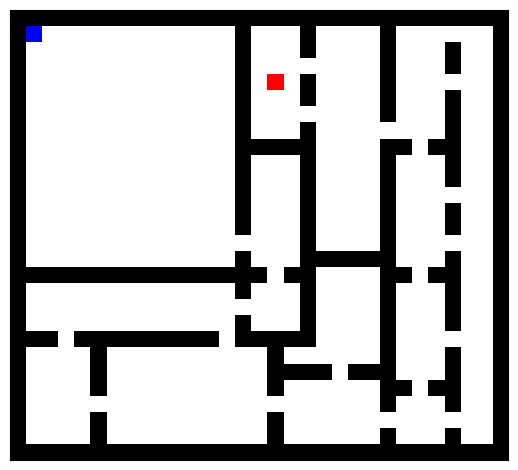

Initial State: (1, 1)


In [13]:
from lab_materials_intrinsic import GridWorldEnv

# Initialise the environment object.
env = GridWorldEnv()

# Reset the environment to an initial state.
state = env.reset()

# Render the initial state.
%matplotlib inline
env.render()
print(f"Initial State: {state}")

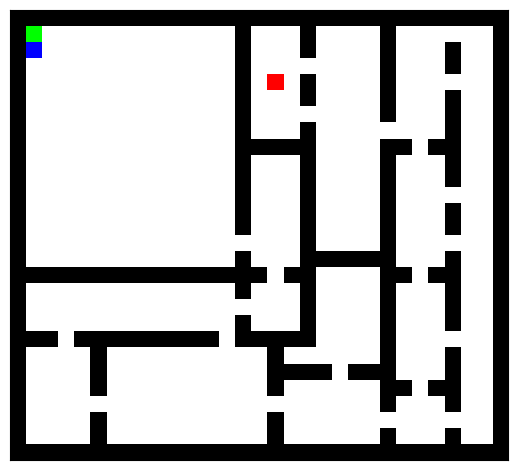

(State: (1, 1), Action: 1) --> (Reward: -0.01, Next-State: (2, 1))


In [14]:
# Go South one step.
action = 1
next_state, reward, terminal = env.step(action)

# Render environment and print transition information.
env.render()
print(f"(State: {state}, Action: {action}) --> (Reward: {reward}, Next-State: {next_state})")

## Basic Q-Learning

Below, we have provided you with a class implementing a standard **tabular Q-Learning** agent.

### What to look for in the code below.

- Action-value estimates are stored in a dictionary `q_table[(state, action)]`.
- Actions are chosen using an **ε-greedy** exploration strategy:
  - with probability `epsilon`, choose a random action;
  - otherwise choose an action with maximal value (with ties being broken uniformly at random).
- The update is the usual one-step Q-Learning target:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right)
$$

Read the implementation below carefully: you will extend it to develop your intrinsically motivated reinforcement learning agents.


In [15]:
import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List, Callable

import numpy as np
import matplotlib.pyplot as plt

from lab_materials_intrinsic import GridWorldEnv


# The state returned by reset/step is a tuple of ints (y, x).
State = Tuple[int, int]

# Actions to be provided as input to step are ints.
Action = int

# Dataclass containing parameters to pass to the Q-Learning agent.
@dataclass
class QLearningConfig:
    alpha: float = 0.1          # Learning rate
    gamma: float = 1.0          # Discount factor
    epsilon: float = 0.1        # Epsilon-greedy exploration chance
    intrinsic_beta: float = 0.1 # Weight applied to intrinsic reward


class TabularQLearningAgent:
    """
    Standard tabular Q-learning with dict-backed Q-table.
    q_table[(s,a)] = Q(s,a)
    """

    def __init__(self, cfg: QLearningConfig, num_actions: int):
        self.cfg = cfg
        self.num_actions = num_actions
        self.q_table: Dict[Tuple[State, Action], float] = {}

    def get_q(self, s: State, a: Action) -> float:
        return self.q_table.get((s, a), 0.0)

    def set_q(self, s: State, a: Action, value: float) -> None:
        self.q_table[(s, a)] = value

    def greedy_action(self, s: State) -> Action:
        q_vals = [self.get_q(s, a) for a in range(self.num_actions)]
        max_q = max(q_vals)
        best_actions = [a for a, q in enumerate(q_vals) if q == max_q]
        return random.choice(best_actions)

    def select_action(self, s: State) -> Action:
        if random.random() < self.cfg.epsilon:
            return random.randrange(self.num_actions)
        return self.greedy_action(s)

    def intrinsic_reward(self, s: State, a: Action, s_next: State, terminal: bool) -> float:
        return 0.0 # You will overwrite this when developing your intrinsically motivated agents.

    def update(self, s: State, a: Action, r_extrinsic: float, s_next: State, terminal: bool) -> float:
        """
        Q-Learning update with total reward:
            r_total = r_extrinsic + beta * r_intrinsic
        Returns raw intrinsic reward (unscaled), for logging.
        """
        r_int = float(self.intrinsic_reward(s, a, s_next, terminal))
        r_total = float(r_extrinsic) + self.cfg.intrinsic_beta * r_int

        q_sa = self.get_q(s, a)
        bootstrap = 0.0 if terminal else max(self.get_q(s_next, a2) for a2 in range(self.num_actions))
        target = r_total + self.cfg.gamma * bootstrap

        self.set_q(s, a, q_sa + self.cfg.alpha * (target - q_sa))
        return r_int


## Novelty-Based Intrinsic Reward (Count-Based Exploration)

We will now extend the basic Q-learning agent with a *novelty-based intrinsic reward*.  
The key idea is to encourage the agent to visit states that it has encountered less frequently.

### State visitation counts

Maintain a dictionary that records how many times each state has been visited.  
Let $N(s)$ denote the number of times the agent has previously visited state $s$.

These counts should be updated **online**, during interaction with the environment.

### Intrinsic reward definition

We define the intrinsic reward for a transition into state $s'$ as

$$
r_{\text{int}}(s') = \frac{1}{1 + N(s')}
$$

This reward has the following properties:

- The first visit to a state yields an intrinsic reward of $1$.
- The intrinsic reward decreases smoothly as the state is revisited.
- The reward is always finite and well-defined, even on the first visit.

### Total reward used for learning

The agent learns using a *shaped* reward that combines extrinsic and intrinsic components:

$$
r_{\text{total}} = r_{\text{ext}} + \beta \, r_{\text{int}}
$$

where $\beta > 0$ controls how strongly novelty influences learning.

### Implementation details

You should implement this by:

- Maintaining a dictionary mapping states to visitation counts.
- Incrementing the count for $s'$ every time the agent transitions into that state.
- Computing the intrinsic reward using the formula above.
- Returning the intrinsic reward so it can be combined with the extrinsic reward during the Q-learning update.

No changes are required to the action-selection mechanism; novelty affects behaviour indirectly through learning.


In [16]:
class NoveltyQLearningAgent(TabularQLearningAgent):
    """
    Count-based novelty intrinsic reward.

    We maintain a visitation count N(s) for each state s, and define the intrinsic reward
    for transitioning into s' as:

        r_int(s') = 1 / (1 + N(s'))

    """
    def __init__(self, cfg: QLearningConfig, num_actions: int):
        super().__init__(cfg, num_actions)
        # TODO: maintain a `counts` dictionary mapping states to visitation counts N(s).
        self.counts: Dict[State, int] = {}
        

    def intrinsic_reward(self, s: State, a: Action, s_next: State, terminal: bool) -> float:
        """
        TODO:
          1) Compute the novelty bonus for s_next using r_int(s_next) = 1 / (1 + N(s_next)).
          2) Increment N(s_next) to record that we've visited s_next one more time.
          3) Return the novelty bonus as the intrinsic reward.
        """
        if s_next not in self.counts:
            self.counts[s_next] = 0
        
        novelty_bonus = 1 / (1 + self.counts[s_next])
        self.counts[s_next] = self.counts[s_next] + 1

        return novelty_bonus


## Curiosity-Based Intrinsic Reward (Prediction Error on Action Effects)

We will now implement a simple curiosity-based intrinsic reward based on *prediction error*.

The key idea is that the agent should be drawn towards transitions where the outcome of its action is hard to predict. As the agent learns a better predictive model of the environment's dynamics, these transitions become less surprising, and the intrinsic reward naturally decreases.

### Predicting action effects (state deltas)

Rather than predicting the absolute next position $(y_{t+1}, x_{t+1})$, we will predict the *movement* caused by an action in a state (i.e. the **state delta**):

$$
(\Delta y_t, \Delta x_t) = (y_{t+1} - y_t,\; x_{t+1} - x_t).
$$

This is a good choice in a GridWorld because the movement produced by an action is naturally bounded and easy to interpret:
- Each component typically lies in $\{-1, 0, +1\}$ (e.g. moving into a wall can give $\Delta y = 0$ and $\Delta x = 0$).
- The scale of the prediction error does not depend on the overall size of the grid.

### Transition model

Maintain a tabular "forward dynamics" model that maps each state–action pair to a predicted movement:

$$
\hat f(s, a) = (\widehat{\Delta y}, \widehat{\Delta x}).
$$

This model should be updated online as the agent interacts with the environment.

### Intrinsic reward definition

We define the intrinsic reward as the **mean squared error (MSE)** between the predicted movement and the true movement:

$$
r_{\text{int}}(s,a,s') = \frac{1}{2}
\left[
(\Delta y - \widehat{\Delta y})^2 +
(\Delta x - \widehat{\Delta x})^2
\right].
$$

This gives a larger intrinsic reward when the model's prediction is poor, and a smaller intrinsic reward once the model has learned to predict the effects of actions reliably.

### Soft model update

After observing the true movement $(\Delta y, \Delta x)$, update the prediction for the visited state-action pair using a soft update with learning rate $\eta$:

$$
\widehat{\Delta y} \leftarrow \widehat{\Delta y} + \eta(\Delta y - \widehat{\Delta y}),
\qquad
\widehat{\Delta x} \leftarrow \widehat{\Delta x} + \eta(\Delta x - \widehat{\Delta x}).
$$

### Total reward used for learning

As before, Q-Learning uses the shaped reward:

$$
r_{\text{total}} = r_{\text{ext}} + \beta \, r_{\text{int}},
$$

where $\beta > 0$ determines how strongly curiosity affects learning.


In [19]:
@dataclass
class CuriosityConfig(QLearningConfig):
    model_lr: float = 0.05  # learning rate for the prediction model updates.


class CuriosityQLearningAgent(TabularQLearningAgent):
    """
    Curiosity via prediction error on *action effects* (state deltas).

    We maintain a tabular transition model:
        pred[(s, a)] = (dy_pred, dx_pred)

    where (dy_pred, dx_pred) is the predicted movement caused by taking action a in state s.

    For a transition s -> s' after taking action a, the true movement is:
        dy_true = y' - y
        dx_true = x' - x

    Intrinsic reward:
        Mean squared error (MSE) between predicted and true movements:
            mse = ((dy_true - dy_pred)^2 + (dx_true - dx_pred)^2) / 2
    """

    def __init__(self, cfg: CuriosityConfig, num_actions: int):
        super().__init__(cfg, num_actions)
        self.model_lr = cfg.model_lr

        # TODO: Maintain a `pred` dictionary mapping state-action pairs to predicted movements in the (x, y) direction.
        self.pred: Dict[Tuple[State, Action], Tuple[float, float]] = {}

    def _init_pred(self) -> Tuple[float, float]:
        """
        TODO: return an initial prediction (dy_pred, dx_pred).

        Hint: dy and dx are typically in {-1, 0, +1} in a GridWorld, so a small
        random initialisation in [-1, 1] is reasonable.
        """
        import random
        dy_pred = random.uniform(-1, 1)
        dx_pred = random.uniform(-1, 1)

        return (dy_pred, dx_pred)

    def _get_pred(self, s: State, a: Action) -> Tuple[float, float]:
        """
        TODO: fetch the current prediction for (s, a), initialising it with _init_pred()
        if this is the first time we've seen the given state-action pair.
        """

        if (s,a) not in self.pred:
            self.pred[(s, a)] = self._init_pred()

        return self.pred[(s, a)]
        
    def intrinsic_reward(self, s: State, a: Action, s_next: State, terminal: bool) -> float:
        """
        TODO:
          1) Get (dy_pred, dx_pred) for (s, a).
          2) Compute the true movement (dy_true, dx_true) using s and the observed s_next.
          3) Compute the MSE prediction error:
                 mse = ((dy_true - dy_pred)^2 + (dx_true - dx_pred)^2) / 2
          4) Soft-update the prediction using model_lr:
                 dy_pred <- dy_pred + lr * (dy_true - dy_pred)
                 dx_pred <- dx_pred + lr * (dx_true - dx_pred)
          5) Return the prediction error as the intrinsic reward.
        """
        dy_pred, dx_pred = self._get_pred(s, a)
        
        y, x = s
        y_next, x_next = s_next
        
        dy_true, dx_true = float(y_next - y), float(x_next - x)

        mse = 0.5*(dy_true - dy_pred)**2 + 0.5*(dx_true - dx_pred)**2
        dy_pred = dy_pred + self.model_lr * (dy_true - dy_pred)
        dx_pred = dx_pred + self.model_lr * (dx_true - dx_pred)

        self.pred[(s, a)] = (dy_pred, dx_pred)
        
        return mse

## Evaluation

We will evaluate exploration behaviour using **state visitation heatmaps**.

### What We Measure

For each agent we will:

1. Run the agent for a fixed number of **environment steps** (across episode boundaries).
2. Count how many times each grid cell is visited.
3. Average the visitation counts over multiple random seeds.
4. Average the total number of states visited by each agent (a metric known as **state coverage**).

### How to Read the Plots

- The more times an agent visits a state, the brighter it is shown on the heatmap.


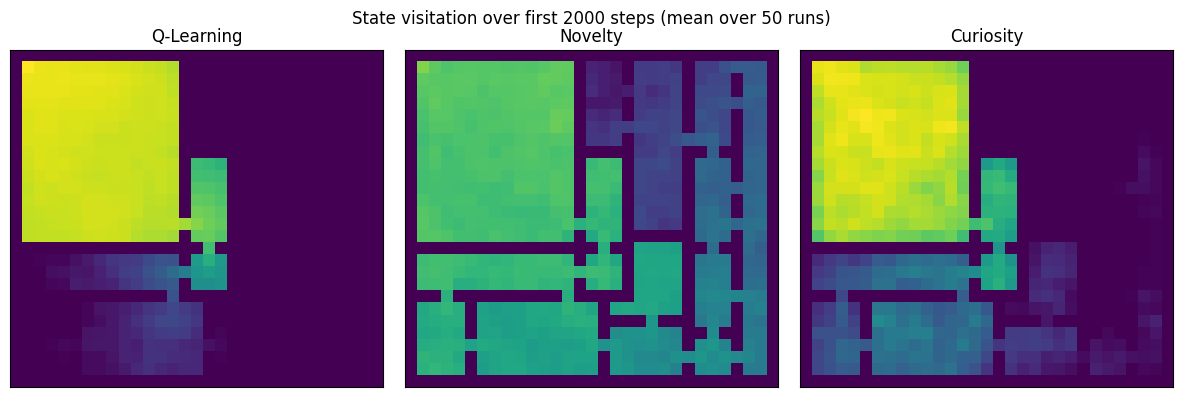

State Coverage:
	Q-Learning:	 331 states.
	Novelty:	 617 states.
	Curiosity:	 456 states.


In [20]:
from lab_materials_intrinsic import collect_visitation_counts, average_visitation_counts, plot_visitation_heatmaps, coverage

NUM_STEPS = 2000
NUM_RUNS = 50

def make_env() -> GridWorldEnv:
    return GridWorldEnv()

def make_base_agent(env: GridWorldEnv) -> TabularQLearningAgent:
    cfg = QLearningConfig(alpha=0.2, gamma=1.0, epsilon=0.0, intrinsic_beta=0.0)
    return TabularQLearningAgent(cfg, num_actions=env.num_actions)

def make_novelty_agent(env: GridWorldEnv) -> NoveltyQLearningAgent:
    cfg = QLearningConfig(alpha=0.2, gamma=1.0, epsilon=0.0, intrinsic_beta=0.01)
    return NoveltyQLearningAgent(cfg, num_actions=env.num_actions)

def make_curiosity_agent(env: GridWorldEnv) -> CuriosityQLearningAgent:
    cfg = CuriosityConfig(alpha=0.2, gamma=1.0, epsilon=0.0, intrinsic_beta=0.01, model_lr=0.15)
    return CuriosityQLearningAgent(cfg, num_actions=env.num_actions)

counts_q = average_visitation_counts(make_env, make_base_agent, num_steps=NUM_STEPS, num_runs=NUM_RUNS)
counts_n = average_visitation_counts(make_env, make_novelty_agent, num_steps=NUM_STEPS, num_runs=NUM_RUNS)
counts_c = average_visitation_counts(make_env, make_curiosity_agent, num_steps=NUM_STEPS, num_runs=NUM_RUNS)

plot_visitation_heatmaps(
    {"Q-Learning": counts_q, "Novelty": counts_n, "Curiosity": counts_c},
    title=f"State visitation over first {NUM_STEPS} steps (mean over {NUM_RUNS} runs)",
    log_scale=True,
    per_panel_normalise=False,
    shared_colour_scale=True,
)

print("State Coverage:")
print(f"\tQ-Learning:\t {coverage(counts_q)} states.")
print(f"\tNovelty:\t {coverage(counts_n)} states.")
print(f"\tCuriosity:\t {coverage(counts_c)} states.")
